In [1]:
# Install these packages if running from colab
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install transformers --quiet

     |████████████████████████████████| 5.5 MB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 78.6 MB/s 
     |████████████████████████████████| 182 kB 55.5 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#let's make longer output readable without scrolling
from pprint import pprint

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# define paths in colab
model_path = 'drive/MyDrive/Colab Notebooks/w266_project_models/'
csv_path = 'drive/MyDrive/Colab Notebooks/w266_project_predictions/'

In [5]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [6]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


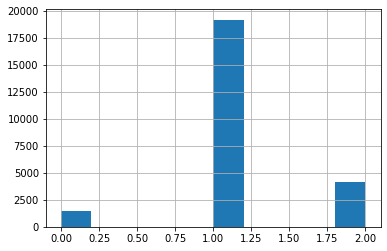

In [7]:
df['class'].hist()

In [8]:
df['tweet'].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

Light Data Cleaning

In [9]:
df['tweet'][0].split(": ")[1:]

["As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."]

In [10]:
# Remove the initial exclamation points and the RT twitter handles
df['tweet'] = df['tweet'].apply(lambda x: ": ".join(x.split(": ")[1:]) if len(x.split(": ")) > 1 else x)
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                       @viva_based she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    @20_Pearls @corey_emanuel right! His TL is tra...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [11]:
# remove the unicode symbols 
import re
df['tweet'] = df['tweet'].apply(lambda x: re.sub("&#\d+","",x))

# remove other @handles 
df['tweet'] = df['tweet'].apply(lambda x: re.sub("@[^ ]+ ","",x))
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    right! His TL is trash ;. Now, mine? Bible scr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [12]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...
...,...,...,...,...,...,...
25291,3,0,2,1,1,"right! His TL is trash ;. Now, mine? Bible scr..."
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Very large skew towards offensive langauge in the dataset

In [13]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25, stratify = df['class'])
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25, stratify = testing_tweets['class'])

In [14]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


In [15]:
#class_weight = n_samples / (n_classes * np.bincount(y))
print('training dataset class weights = ', training_tweets.shape[0] / (3 * np.bincount(training_tweets['class'])))
print('valid dataset class weights = ', valid_tweets.shape[0] / (3 * np.bincount(valid_tweets['class'])))
print('test dataset class weights = ', testing_tweets.shape[0] / (3 * np.bincount(testing_tweets['class'])))

training dataset class weights =  [5.77680653 0.43047594 1.98458458]
valid dataset class weights =  [5.77622378 0.43043252 1.98557692]
test dataset class weights =  [5.77855478 0.43060622 1.98161471]


Based on this 5.78:0.43:1.98 ratio, we will 'weight' them by using class_weight option.



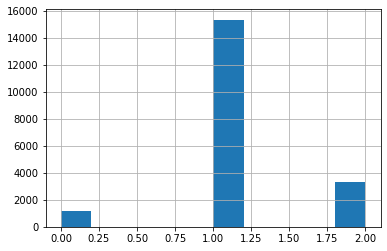

In [16]:
training_tweets['class'].hist()

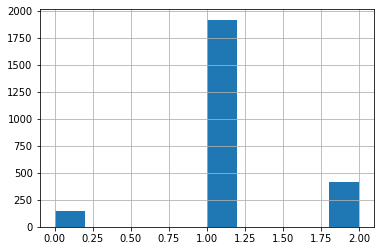

In [17]:
valid_tweets['class'].hist()

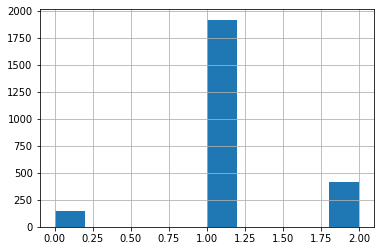

In [18]:
testing_tweets['class'].hist()

In [19]:
# get average length of tweets in the various sets
print("Average word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print("Min max word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).min())
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).max())

print("Average character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x)).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x)).mean())

print("Min max character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).min())
print(training_tweets['tweet'].apply(lambda x: len(x)).max())

Average word length
12.859427015030768
12.792171105730429
12.939491730536506
Min max word length
1
36
Average character length
68.69106224150106
68.10290556900726
68.71803146430013
Min max character length
1
148


## Model hyperparameters

In [20]:
max_length = 65

In [21]:
#class_weight = n_samples / (n_classes * np.bincount(y))
print('test dataset class weights = ', testing_tweets.shape[0] / (3 * np.bincount(testing_tweets['class'])))

test dataset class weights =  [5.77855478 0.43060622 1.98161471]


We will 'weight' them by using class_weight option to balance our classification.

In [22]:
class_weight = dict(enumerate(testing_tweets.shape[0] / (3 * np.bincount(testing_tweets['class']))))

In [23]:
class_weight

{0: 5.778554778554779, 1: 0.4306062185165885, 2: 1.9816147082334132}

### BERT Tweet Model

In [24]:
model_checkpoint = 'vinai/bertweet-base'
model_name = 'davidson_bertweet_balanced_weights.hdf5'

In [25]:
# Place to save CHECKPOINTS
checkpoint_filepath = model_path + model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [26]:
from transformers import AutoModel, AutoTokenizer, TFAutoModel

bertweet_model = TFAutoModel.from_pretrained(model_checkpoint)
bertweet_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [27]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bertweet_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bertweet_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bertweet_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [28]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 65)
valid_encodings shape =  (2478, 65)
test_encodings shape =  (2479, 65)


In [29]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[    0,   105,   238, ...,     1,     1,     1],
       [    0,  5614, 15700, ...,     1,     1,     1],
       [    0,   545,   224, ...,     1,     1,     1],
       ...,
       [    0,  1071,   413, ...,     1,     1,     1],
       [    0, 26324,    14, ...,     1,     1,     1],
       [    0,     8,   253, ...,     1,     1,     1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [30]:
def create_bertweet_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bertweet_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

### different hyperparameters

In [31]:
#hidden_size_list = [16, 32, 64, 128, 256]
#for hidden_size in hidden_size_list:
#  pooled_bertweet_model = create_bertweet_model(checkpoint = model_checkpoint, hidden_size = hidden_size)
#  pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
#                                                  np.array(training_tweets['class']),   
#                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
#                                                  np.array(valid_tweets['class'])),    
#                                                  batch_size=32, 
#                                                  epochs=1,
#                                                  class_weight=class_weight) 

hidden_size = 66 is good. Now try different dropouts

In [32]:
#dropout_size_list = [0.1,0.3,0.5,0.8]
#for dropout_size in dropout_size_list:
#  pooled_bertweet_model = create_bertweet_model(checkpoint = model_checkpoint, hidden_size = 66, dropout=dropout_size)
#  pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
#                                                  np.array(training_tweets['class']),   
#                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
#                                                  np.array(valid_tweets['class'])),    
#                                                  batch_size=32, 
#                                                  epochs=1,
#                                                  class_weight=class_weight) 

hidden_size = 66, dropouts = 0.1. Now try different learning_rate

In [33]:
#learning_rate_list = [0.00001,0.00002,0.00005]
#for learning_rate in learning_rate_list:
#  pooled_bertweet_model = create_bertweet_model(checkpoint = model_checkpoint, hidden_size = 66, dropout=0.5, learning_rate=learning_rate)
#  pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
#                                                  np.array(training_tweets['class']),   
#                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
#                                                  np.array(valid_tweets['class'])),    
#                                                  batch_size=32, 
#                                                  epochs=1,
#                                                  class_weight=class_weight) 


In [34]:
pooled_bertweet_model = create_bertweet_model()
pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback], 
                                                  class_weight=class_weight) 
bertweet_score = pooled_bertweet_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bertweet_score[0]) 
print('Test accuracy:', bertweet_score[1]) 

78/78 [==============================] - 11s 136ms/step - loss: 0.6872 - accuracy: 0.7031
Test loss: 0.6872096657752991
Test accuracy: 0.7031061053276062


In [35]:
pooled_bertweet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 65)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                              

In [36]:
predictions = pooled_bertweet_model.predict([test_encodings.input_ids, 
                                             test_encodings.token_type_ids, 
                                             test_encodings.attention_mask])

78/78 [==============================] - 13s 135ms/step


In [37]:
prediction_classes = predictions.argmax(axis=-1)
prediction_classes

array([0, 2, 2, ..., 2, 1, 2])

In [38]:
#pred_dict = {'org_class': testing_tweets['class'], 'pred_class': prediction_classes}
pred_dict = {'test_predictions': prediction_classes, 'test_labels': testing_tweets['class']}  
       
df = pd.DataFrame(pred_dict)

In [39]:
# Save Result to a CSV file
# org_class, org_input, pred_class, output, output_class
save_csv_dict = {'org_class': testing_tweets['class'], 'org_input': testing_tweets['tweet'], 'pred_class': prediction_classes}  
       
df_pred = pd.DataFrame(save_csv_dict) 
# # saving the output dataframe to a csv file
output_file_name = 'davidson_bertweet_class_pred.csv'
df_pred.to_csv(csv_path + output_file_name, index = False) 

In [40]:
zero_labels = df[df['test_labels']==0]
one_labels = df[df['test_labels']==1]
two_labels = df[df['test_labels']==2]
print(len(zero_labels))
print(len(one_labels))
print(len(two_labels))

143
1919
417


In [41]:
incorrect_zero_labels = zero_labels[zero_labels['test_labels'] != zero_labels['test_predictions']]
incorrect_one_labels = one_labels[one_labels['test_labels'] != one_labels['test_predictions']]
incorrect_two_labels = two_labels[two_labels['test_labels'] != two_labels['test_predictions']]
print(len(incorrect_zero_labels))
print(len(incorrect_one_labels))
print(len(incorrect_two_labels))

19
661
56


In [42]:
correct_zero_labels = zero_labels[zero_labels['test_labels'] == zero_labels['test_predictions']]
correct_one_labels = one_labels[one_labels['test_labels'] == one_labels['test_predictions']]
correct_two_labels = two_labels[two_labels['test_labels'] == two_labels['test_predictions']]
print(len(correct_zero_labels))
print(len(correct_one_labels))
print(len(correct_two_labels))

124
1258
361


In [43]:
print("Accuracy for hate speech class (0): ", len(correct_zero_labels)/len(zero_labels))
print("Accuracy for offensive language class (1): ", len(correct_one_labels)/len(one_labels))
print("Accuracy for neither class (2): ", len(correct_two_labels)/len(two_labels))

Accuracy for hate speech class (0):  0.8671328671328671
Accuracy for offensive language class (1):  0.655549765502866
Accuracy for neither class (2):  0.8657074340527577


In [44]:
bertweet_score.append(len(correct_zero_labels)/len(zero_labels))
bertweet_score.append(len(correct_one_labels)/len(one_labels))
bertweet_score.append(len(correct_two_labels)/len(two_labels))
bertweet_score

[0.6872096657752991,
 0.7031061053276062,
 0.8671328671328671,
 0.655549765502866,
 0.8657074340527577]

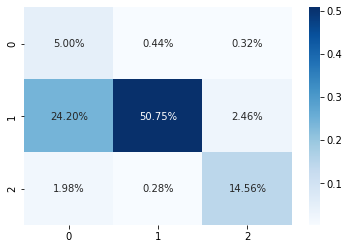

In [45]:
tweet_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

### BERT Uncase Model

In [46]:
model_checkpoint = 'bert-base-uncased'
model_name = 'davidson_bert_balanced_weights.hdf5'

In [47]:
# Place to save CHECKPOINTS
checkpoint_filepath = model_path + model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [48]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [50]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 65)
valid_encodings shape =  (2478, 65)
test_encodings shape =  (2479, 65)


In [51]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  2123,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       ...,
       [  101,  8112,  7110, ...,     0,     0,     0],
       [  101,  9152, 23033, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [52]:
def create_bert_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [53]:
pooled_bert_model = create_bert_model()
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback],
                                                  class_weight=class_weight) 
bert_score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bert_score[0]) 
print('Test accuracy:', bert_score[1]) 

78/78 [==============================] - 11s 141ms/step - loss: 0.5584 - accuracy: 0.7648
Test loss: 0.5583718419075012
Test accuracy: 0.7648245096206665


In [54]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 65)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                              

In [55]:
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

78/78 [==============================] - 14s 140ms/step


In [56]:
prediction_classes = predictions.argmax(axis=-1)
prediction_classes

array([1, 2, 2, ..., 2, 1, 2])

In [57]:
pred_dict = {'test_predictions': prediction_classes, 'test_labels': testing_tweets['class']}  
       
df = pd.DataFrame(pred_dict)

In [58]:
# Save Result to a CSV file
# org_class, org_input, pred_class, output, output_class
save_csv_dict = {'org_class': testing_tweets['class'], 'org_input': testing_tweets['tweet'], 'pred_class': prediction_classes}  
       
df_pred = pd.DataFrame(save_csv_dict) 
# # saving the output dataframe to a csv file
output_file_name = 'davidson_bert_class_pred.csv'
df_pred.to_csv(csv_path + output_file_name, index = False) 

In [59]:
zero_labels = df[df['test_labels']==0]
one_labels = df[df['test_labels']==1]
two_labels = df[df['test_labels']==2]
print(len(zero_labels))
print(len(one_labels))
print(len(two_labels))

143
1919
417


In [60]:
incorrect_zero_labels = zero_labels[zero_labels['test_labels'] != zero_labels['test_predictions']]
incorrect_one_labels = one_labels[one_labels['test_labels'] != one_labels['test_predictions']]
incorrect_two_labels = two_labels[two_labels['test_labels'] != two_labels['test_predictions']]
print(len(incorrect_zero_labels))
print(len(incorrect_one_labels))
print(len(incorrect_two_labels))

34
502
47


In [61]:
correct_zero_labels = zero_labels[zero_labels['test_labels'] == zero_labels['test_predictions']]
correct_one_labels = one_labels[one_labels['test_labels'] == one_labels['test_predictions']]
correct_two_labels = two_labels[two_labels['test_labels'] == two_labels['test_predictions']]
print(len(correct_zero_labels))
print(len(correct_one_labels))
print(len(correct_two_labels))

109
1417
370


In [62]:
print("Accuracy for hate speech class (0): ", len(correct_zero_labels)/len(zero_labels))
print("Accuracy for offensive language class (1): ", len(correct_one_labels)/len(one_labels))
print("Accuracy for neither class (2): ", len(correct_two_labels)/len(two_labels))

Accuracy for hate speech class (0):  0.7622377622377622
Accuracy for offensive language class (1):  0.7384054194893174
Accuracy for neither class (2):  0.8872901678657075


In [63]:
bert_score

[0.5583718419075012, 0.7648245096206665]

In [64]:
bert_score.append(len(correct_zero_labels)/len(zero_labels))
bert_score.append(len(correct_one_labels)/len(one_labels))
bert_score.append(len(correct_two_labels)/len(two_labels))
bert_score

[0.5583718419075012,
 0.7648245096206665,
 0.7622377622377622,
 0.7384054194893174,
 0.8872901678657075]

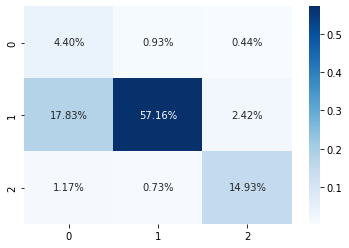

In [65]:
bert_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(bert_cf/np.sum(bert_cf), annot=True, fmt='.2%', cmap='Blues')

### BERT Large Uncase Model

In [66]:
model_checkpoint = 'bert-large-uncased'
model_name = 'davidson_bertlarge_balanced_weights.hdf5'

In [67]:
# Place to save CHECKPOINTS
checkpoint_filepath = model_path + model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [68]:
from transformers import BertTokenizer, TFBertModel

bert_large_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_large_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [69]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_large_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_large_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_large_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [70]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 65)
valid_encodings shape =  (2478, 65)
test_encodings shape =  (2479, 65)


In [71]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  2123,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       ...,
       [  101,  8112,  7110, ...,     0,     0,     0],
       [  101,  9152, 23033, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [72]:
def create_bert_large_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_large_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [73]:
pooled_bert_large_model = create_bert_large_model()
pooled_bert_large_model_history = pooled_bert_large_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback],
                                                  class_weight=class_weight) 
bert_large_score = pooled_bert_large_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bert_large_score[0]) 
print('Test accuracy:', bert_large_score[1]) 

78/78 [==============================] - 35s 442ms/step - loss: 1.1322 - accuracy: 0.0577
Test loss: 1.132192611694336
Test accuracy: 0.05768455192446709


In [74]:
pooled_bert_large_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 65)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                              

In [75]:
predictions = pooled_bert_large_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

78/78 [==============================] - 39s 435ms/step


In [76]:
prediction_classes = predictions.argmax(axis=-1)
prediction_classes

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
pred_dict = {'test_predictions': prediction_classes, 'test_labels': testing_tweets['class']}  
       
df = pd.DataFrame(pred_dict)

In [78]:
# Save Result to a CSV file
# org_class, org_input, pred_class, output, output_class
save_csv_dict = {'org_class': testing_tweets['class'], 'org_input': testing_tweets['tweet'], 'pred_class': prediction_classes}  
       
df_pred = pd.DataFrame(save_csv_dict) 
# # saving the output dataframe to a csv file
output_file_name = 'davidson_bertlarge_class_pred.csv'
df_pred.to_csv(csv_path + output_file_name, index = False) 

In [79]:
zero_labels = df[df['test_labels']==0]
one_labels = df[df['test_labels']==1]
two_labels = df[df['test_labels']==2]
print(len(zero_labels))
print(len(one_labels))
print(len(two_labels))

143
1919
417


In [80]:
incorrect_zero_labels = zero_labels[zero_labels['test_labels'] != zero_labels['test_predictions']]
incorrect_one_labels = one_labels[one_labels['test_labels'] != one_labels['test_predictions']]
incorrect_two_labels = two_labels[two_labels['test_labels'] != two_labels['test_predictions']]
print(len(incorrect_zero_labels))
print(len(incorrect_one_labels))
print(len(incorrect_two_labels))

0
1919
417


In [81]:
correct_zero_labels = zero_labels[zero_labels['test_labels'] == zero_labels['test_predictions']]
correct_one_labels = one_labels[one_labels['test_labels'] == one_labels['test_predictions']]
correct_two_labels = two_labels[two_labels['test_labels'] == two_labels['test_predictions']]
print(len(correct_zero_labels))
print(len(correct_one_labels))
print(len(correct_two_labels))

143
0
0


In [82]:
print("Accuracy for hate speech class (0): ", len(correct_zero_labels)/len(zero_labels))
print("Accuracy for offensive language class (1): ", len(correct_one_labels)/len(one_labels))
print("Accuracy for neither class (2): ", len(correct_two_labels)/len(two_labels))

Accuracy for hate speech class (0):  1.0
Accuracy for offensive language class (1):  0.0
Accuracy for neither class (2):  0.0


In [83]:
bert_large_score.append(len(correct_zero_labels)/len(zero_labels))
bert_large_score.append(len(correct_one_labels)/len(one_labels))
bert_large_score.append(len(correct_two_labels)/len(two_labels))
bert_large_score

[1.132192611694336, 0.05768455192446709, 1.0, 0.0, 0.0]

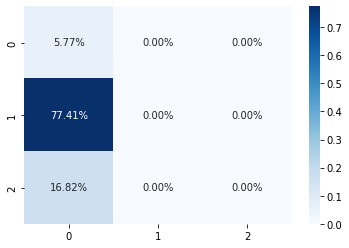

In [84]:
large_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(large_cf/np.sum(large_cf), annot=True, fmt='.2%', cmap='Blues')

### Outputs

In [85]:
output_dic = {'loss': [bertweet_score[0], bert_score[0], bert_large_score[0]], 
              'accuracy': [bertweet_score[1], bert_score[1], bert_large_score[1]],
              'hate accuracy': [bertweet_score[2], bert_score[2], bert_large_score[2]],
              'offensive accuracy': [bertweet_score[3], bert_score[3], bert_large_score[3]],
              'neither accuracy': [bertweet_score[4], bert_score[4], bert_large_score[4]],
              }

In [86]:
output_dic

{'loss': [0.6872096657752991, 0.5583718419075012, 1.132192611694336],
 'accuracy': [0.7031061053276062, 0.7648245096206665, 0.05768455192446709],
 'hate accuracy': [0.8671328671328671, 0.7622377622377622, 1.0],
 'offensive accuracy': [0.655549765502866, 0.7384054194893174, 0.0],
 'neither accuracy': [0.8657074340527577, 0.8872901678657075, 0.0]}

In [87]:
# row 0 = bertweet
# row 1 = bert uncase
# row 2 = bert large uncase

df_outpout = pd.DataFrame(data=output_dic)
df_outpout

,loss,accuracy,hate accuracy,offensive accuracy,neither accuracy
0,0.687210,0.703106,0.867133,0.655550,0.865707
1,0.558372,0.764825,0.762238,0.738405,0.887290
2,1.132193,0.057685,1.000000,0.000000,0.000000
